In [1]:
!pip install tensorflow matplotlib seaborn pillow scikit-learn deepstack pydicom

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow import keras
from deepstack.base import KerasMember
import requests
from io import BytesIO
import cv2
from glob import glob

In [3]:
DATASET_PATH = "/content/drive/MyDrive/dataset_augmented"

In [4]:
inme_var_path = os.path.join(DATASET_PATH, "İnmeVar")
inme_yok_path = os.path.join(DATASET_PATH, "İnmeYok")

In [5]:
# Tüm dosya yollarını al ve etiketle
inme_var_files = sorted(glob(os.path.join(inme_var_path, "*.png")))
inme_yok_files = sorted(glob(os.path.join(inme_yok_path, "*.png")))

In [6]:
# İnme Var ve İnme Yok görsellerinin sayısını yazdır
inme_var_count = len(inme_var_files)
inme_yok_count = len(inme_yok_files)

print(f"İnme Var Görselleri Sayısı: {inme_var_count}")
print(f"İnme Yok Görselleri Sayısı: {inme_yok_count}")

İnme Var Görselleri Sayısı: 13302
İnme Yok Görselleri Sayısı: 9088


In [7]:
# DataFrame oluştur
data = pd.DataFrame({
    "image_path": inme_var_files + inme_yok_files,
    "label": [1] * len(inme_var_files) + [0] * len(inme_yok_files)  # 1: İnme Var, 0: İnme Yok
})

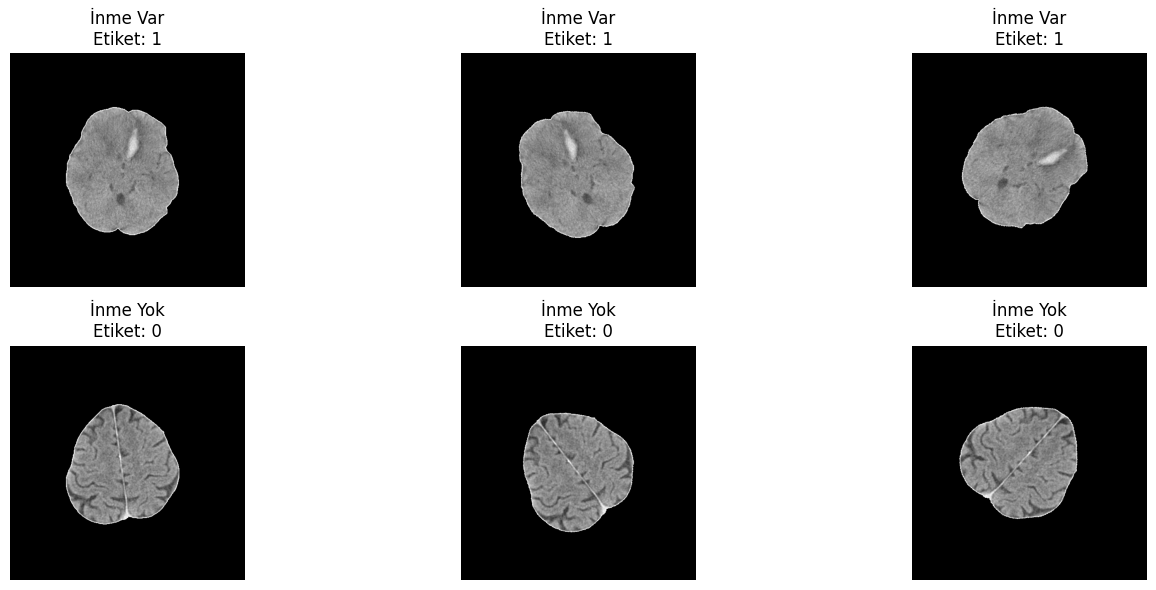

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# İnme Var ve İnme Yok görsellerinin ilk 3 örneğini al
inme_var_first_3 = data.iloc[:3]
inme_yok_first_3 = data.iloc[len(inme_var_files):len(inme_var_files)+3]

# Plot başlatma
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 satır, 3 sütun

# İnme Var görselleri
for i, (index, row) in enumerate(inme_var_first_3.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")  # Görseli RGB'ye dönüştür
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'İnme Var\nEtiket: {row["label"]}')
    axes[0, i].axis('off')  # Eksenleri kapat

# İnme Yok görselleri
for i, (index, row) in enumerate(inme_yok_first_3.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")  # Görseli RGB'ye dönüştür
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'İnme Yok\nEtiket: {row["label"]}')
    axes[1, i].axis('off')  # Eksenleri kapat

    # Dosya adını görselin üzerine yazdır


# Görselleri göster
plt.tight_layout()
plt.show()



Görsel Yükleniyor: 100%|██████████| 22390/22390 [00:00<00:00, 5155100.54it/s]


Yüklenen görsellerin sayısı: 22390
İlk Görsel Yolu: /content/drive/MyDrive/dataset_augmented/İnmeVar/10002_1.png
İlk Etiket: 1


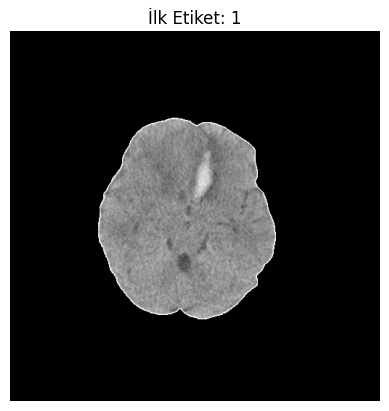

In [9]:
import cv2
import numpy as np
import multiprocessing
from tqdm import tqdm

IMG_SIZE = (224, 224)

def process_image(img_path, label):
    # Görseli okuma
    img = cv2.imread(img_path)

    # Eğer görsel yüklenememişse, None döndür
    if img is None:
        print(f"Bozuk veya geçersiz görsel: {img_path}")
        return None, None

    # Görseli RGB'ye dönüştürme
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Görseli yeniden boyutlandırma
    img = cv2.resize(img, IMG_SIZE)

    # Normalizasyon: Piksel değerlerini [0, 1] aralığına getirme
    img = img.astype("float32") / 255.0

    return img, label

def load_and_preprocess_images(image_paths, labels):
    images = []
    valid_image_paths = []  # Geçerli görsel yollarını burada tutacağız
    valid_labels = []  # Geçerli etiketler

    # İlk görsel ve etiketi almak için
    first_image_path = None
    first_label = None

    # multiprocessing ile paralel işlem için argümanları oluşturuyoruz
    args = list(zip(image_paths, labels))

    # multiprocessing ile işlem paralelleştirilmiş
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.starmap(process_image, args), total=len(image_paths), desc="Görsel Yükleniyor"))

    # Sonuçları işle
    for i, (img, label) in enumerate(results):
        if img is not None:
            if first_image_path is None:
                first_image_path = image_paths[i]
                first_label = label

            images.append(img)
            valid_image_paths.append(image_paths[i])  # Geçerli görsel yolunu ekle
            valid_labels.append(label)  # Geçerli etiketi ekle

    # Görselleri ve etiketleri numpy dizilerine dönüştürme
    images = np.array(images)
    labels = np.array(valid_labels)

    # İlk görseli ve etiketini döndürme
    return images, labels, first_image_path, first_label

# Örnek kullanım
X, y, first_img_path, first_label = load_and_preprocess_images(inme_var_files + inme_yok_files,
                                                               [1]*len(inme_var_files) + [0]*len(inme_yok_files))

print(f"Yüklenen görsellerin sayısı: {len(X)}")

# İlk görseli ve etiketini yazdırma
print(f"İlk Görsel Yolu: {first_img_path}")
print(f"İlk Etiket: {first_label}")

# İlk görseli görselleştirme
first_img = cv2.imread(first_img_path)
first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.imshow(first_img)
plt.title(f"İlk Etiket: {first_label}")
plt.axis('off')
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Veriyi %70 eğitim, %15 doğrulama, %15 test olarak ayır
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Bölünen veri miktarlarını yazdırma
print(f"Eğitim verisi: {len(X_train)}")
print(f"Doğrulama verisi: {len(X_val)}")
print(f"Test verisi: {len(X_test)}")



Eğitim verisi: 15673
Doğrulama verisi: 3358
Test verisi: 3359


In [11]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-_8v6pybw
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-_8v6pybw
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Conv2D, Input, Add, Reshape

def cbam_block(input_tensor, ratio=8):
    """ CBAM: Convolutional Block Attention Module """

    # **Channel Attention**
    channel = GlobalAveragePooling2D()(input_tensor)
    channel = Dense(input_tensor.shape[-1] // ratio, activation='relu')(channel)
    channel = Dense(input_tensor.shape[-1], activation='sigmoid')(channel)
    channel = Reshape((1, 1, input_tensor.shape[-1]))(channel)
    channel_attention = Multiply()([input_tensor, channel])

    # **Spatial Attention**
    spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_attention)
    spatial_attention = Multiply()([channel_attention, spatial])

    return spatial_attention


In [13]:
from tensorflow.keras.models import Model
from classification_models.tfkeras import Classifiers  # ResNet18 desteği
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# ResNet18 modelini al
ResNet18, _ = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# CBAM ekleme
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)  # ResNet18'den özellik çıkarımı
x = cbam_block(x)  # CBAM modülünü ekle
x = GlobalAveragePooling2D()(x)  # Global ortalama havuzlama
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # İkili sınıflandırma (Stroke/No Stroke)

# Modeli oluştur
model1 = Model(inputs, outputs)

# Modeli derle
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Model özetini yazdır
model1.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 7, 7, 512)      │     11,186,889 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ functional[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         32,832 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │         33,280 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 512)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 7, 7, 512)      │              0 │ functional[0][0],      │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 1)        │         25,089 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 7, 7, 512)      │              0 │ multiply[0][0],        │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ multiply_1[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        262,656 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,672,331 (44.53 MB)

 Trainable params: 11,664,389 (44.50 MB)

 Non-trainable params: 7,942 (31.02 KB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Model kaydetme callback'i
checkpoint = ModelCheckpoint("cbam_resnet18_model.h5", monitor="val_loss", save_best_only=True, mode="min")

# Öğrenme oranı azaltma callback'i
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-7)

# Model eğitimi
history = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[checkpoint, reduce_lr]
)



Epoch 1/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8101 - loss: 0.3801

490/490 ━━━━━━━━━━━━━━━━━━━━ 75s 89ms/step - accuracy: 0.8103 - loss: 0.3800 - val_accuracy: 0.4059 - val_loss: 0.9897 - learning_rate: 1.0000e-04
Epoch 2/25
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9405 - loss: 0.1556

490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9405 - loss: 0.1555 - val_accuracy: 0.8460 - val_loss: 0.4490 - learning_rate: 1.0000e-04
Epoch 3/25
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9692 - loss: 0.0835

490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9692 - loss: 0.0835 - val_accuracy: 0.9166 - val_loss: 0.2057 - learning_rate: 1.0000e-04
Epoch 4/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9772 - loss: 0.0618 - val_accuracy: 0.9264 - val_loss: 0.2886 - learning_rate: 1.0000e-04
Epoch 5/25
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9846 - loss: 0.0456

490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9846 - loss: 0.0456 - val_accuracy: 0.9473 - val_loss: 0.1542 - learning_rate: 1.0000e-04
Epoch 6/25
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9845 - loss: 0.0405

490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9845 - loss: 0.0405 - val_accuracy: 0.9598 - val_loss: 0.1142 - learning_rate: 1.0000e-04
Epoch 7/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9913 - loss: 0.0257 - val_accuracy: 0.9571 - val_loss: 0.1631 - learning_rate: 1.0000e-04
Epoch 8/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9929 - loss: 0.0213 - val_accuracy: 0.9565 - val_loss: 0.1837 - learning_rate: 1.0000e-04
Epoch 9/25
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9933 - loss: 0.0182
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9933 - loss: 0.0183 - val_accuracy: 0.9574 - val_loss: 0.1442 - learning_rate: 1.0000e-04
Epoch 10/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9976 - loss: 0.0088

490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9976 - loss: 0.0088 - val_accuracy: 0.9735 - val_loss: 0.1050 - learning_rate: 5.0000e-05
Epoch 11/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9568 - val_loss: 0.1597 - learning_rate: 5.0000e-05
Epoch 12/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9708 - val_loss: 0.1297 - learning_rate: 5.0000e-05
Epoch 13/25
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9986 - loss: 0.0050
Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9986 - loss: 0.0050 - val_accuracy: 0.9726 - val_loss: 0.1123 - learning_rate: 5.0000e-05
Epoch 14/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9714 - val_loss: 0.1442 - learning_rate: 2.5000e-05
Epoch 15/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accurac

In [15]:
# En iyi modeli kaydetme
model1.save("/content/drive/My Drive/cbam_resnet18_final_model.h5")

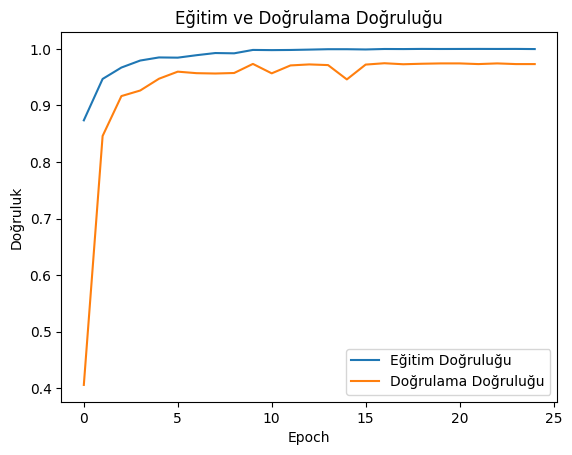

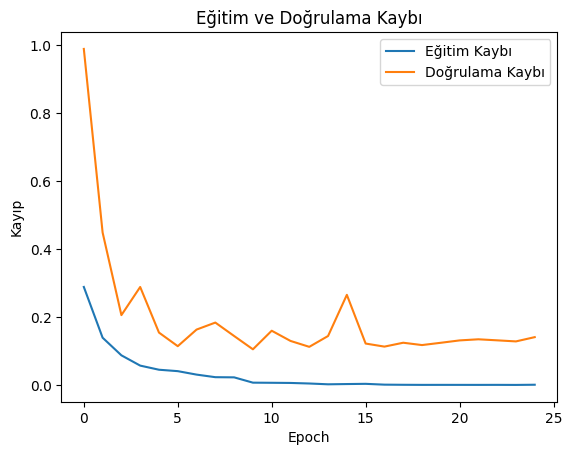

In [16]:
# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


In [18]:
# Modeli Değerlendirme
loss, accuracy = model1.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9679 - loss: 0.1531
Test Loss: 0.15481163561344147, Test Accuracy: 0.9717177748680115


In [20]:
# Tahmin Yapma
y_pred = model1.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 0.5 eşik değeri ile sınıflandırma

105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1363
           1       0.98      0.97      0.98      1996

    accuracy                           0.97      3359
   macro avg       0.97      0.97      0.97      3359
weighted avg       0.97      0.97      0.97      3359

Ortalama F1-score: 0.9708


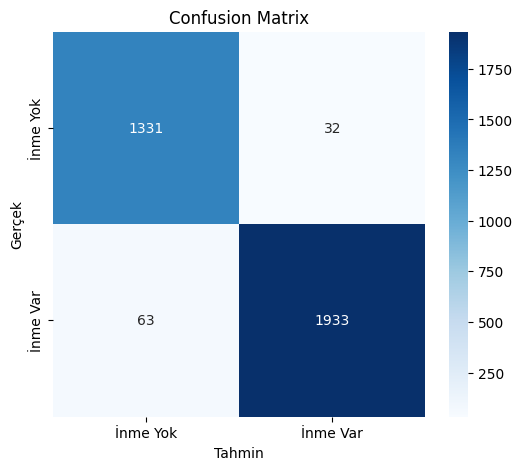

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Classification Report ve Confusion Matrix
report = classification_report(y_test, y_pred_class, output_dict=True)

# Ortalama F1-score hesapla (Makro Ortalama kullanarak)
average_f1_score = report['macro avg']['f1-score']

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print(f"Ortalama F1-score: {average_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['İnme Yok', 'İnme Var'], yticklabels=['İnme Yok', 'İnme Var'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()


In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# VGG16 modelini yükle (önceden eğitilmiş ağırlıklarla, son katmanları çıkarılmış halde)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modelin ağırlıklarını dondur (önceden eğitilmiş katmanları değiştirme)
for layer in base_model.layers:
    layer.trainable = False

# Özel sınıflandırıcı ekleme
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # İkili sınıflandırma için sigmoid aktivasyonu
])

# Modeli derleme
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Modelin özetini yazdır
model2.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,691,841 (105.64 MB)

 Trainable params: 12,977,153 (49.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Erken durdurma ve öğrenme oranı azaltma callback'leri
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Model eğitimi
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6521 - loss: 0.6309 - val_accuracy: 0.8303 - val_loss: 0.3951 - learning_rate: 1.0000e-04
Epoch 2/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7997 - loss: 0.4325 - val_accuracy: 0.8106 - val_loss: 0.4003 - learning_rate: 1.0000e-04
Epoch 3/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8280 - loss: 0.3862 - val_accuracy: 0.8609 - val_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 4/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8446 - loss: 0.3542 - val_accuracy: 0.8642 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 5/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8547 - loss: 0.3321 - val_accuracy: 0.8657 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 6/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8576 - loss: 0.3216 - val_accuracy: 0.8630 - val_loss: 0.3143 - learning_rate: 1.0000e-04
Epoch 7/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/ste

In [26]:
# En iyi modeli kaydetme
model2.save("/content/drive/My Drive/vgg_model.h5")

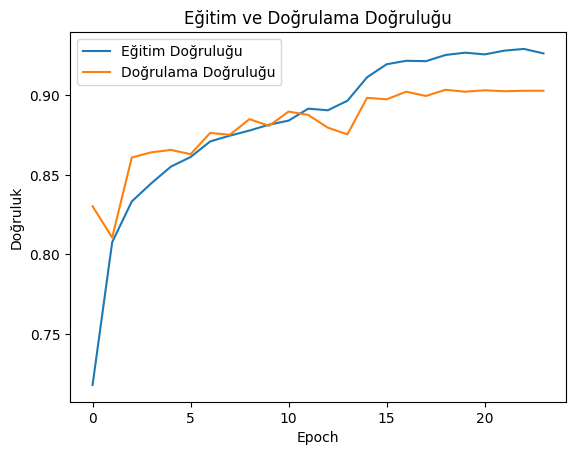

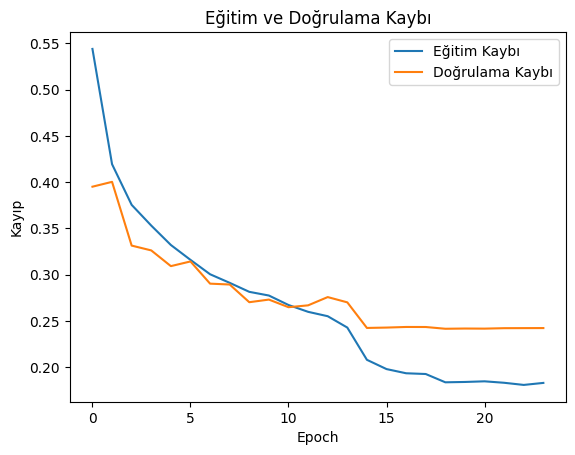

In [27]:
# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


In [28]:
# Modeli Değerlendirme
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8946 - loss: 0.2437
Test Loss: 0.25686365365982056, Test Accuracy: 0.8943138122558594


In [29]:
# Tahmin Yapma
y_pred = model2.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 0.5 eşik değeri ile sınıflandırma

105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1363
           1       0.92      0.90      0.91      1996

    accuracy                           0.89      3359
   macro avg       0.89      0.89      0.89      3359
weighted avg       0.89      0.89      0.89      3359

Ortalama F1-score: 0.8909


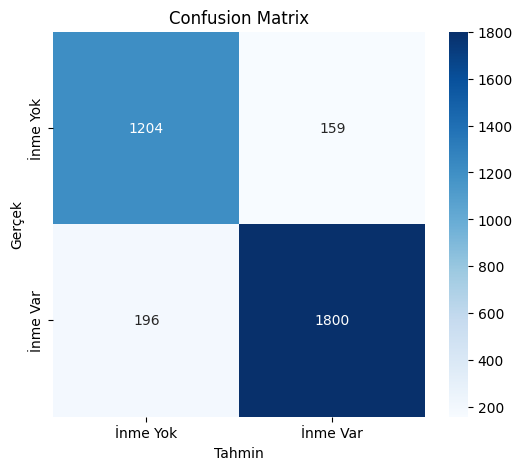

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Classification Report ve Confusion Matrix
report = classification_report(y_test, y_pred_class, output_dict=True)

# Ortalama F1-score hesapla (Makro Ortalama kullanarak)
average_f1_score = report['macro avg']['f1-score']

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print(f"Ortalama F1-score: {average_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['İnme Yok', 'İnme Var'], yticklabels=['İnme Yok', 'İnme Var'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()


In [32]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout

# Fine-tuning için DenseNet121'i yükleyelim
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Tüm katmanları eğitilebilir hale getiriyoruz

# Yeni model katmanları
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)
output_layer = Dense(1, activation="sigmoid")(x)


In [33]:
from tensorflow.keras.optimizers import AdamW

# Modeli oluştur
model3 = Model(inputs=base_model.input, outputs=output_layer)

# Modeli derleme
model3.compile(optimizer=AdamW(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=["accuracy", tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


# Modeli eğitme
history = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[reduce_lr])  # EarlyStopping kaldırıldı



Epoch 1/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 335s 335ms/step - accuracy: 0.7632 - auc: 0.8362 - loss: 0.1966 - precision: 0.8216 - recall: 0.7677 - val_accuracy: 0.7603 - val_auc: 0.9518 - val_loss: 0.2462 - val_precision: 0.7176 - val_recall: 0.9835 - learning_rate: 1.0000e-04
Epoch 2/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.8944 - auc: 0.9592 - loss: 0.0749 - precision: 0.9230 - recall: 0.8982 - val_accuracy: 0.9470 - val_auc: 0.9870 - val_loss: 0.0406 - val_precision: 0.9443 - val_recall: 0.9679 - learning_rate: 1.0000e-04
Epoch 3/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.9394 - auc: 0.9861 - loss: 0.0410 - precision: 0.9486 - recall: 0.9487 - val_accuracy: 0.9395 - val_auc: 0.9865 - val_loss: 0.0392 - val_precision: 0.9476 - val_recall: 0.9509 - learning_rate: 1.0000e-04
Epoch 4/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.9592 - auc: 0.9924 - loss: 0.0294 - precision: 0.9677 - recall: 0.9640 - val_accuracy: 0.9133 - val_auc: 0.9789 - 

In [35]:
# Modeli kaydetme
model3.save("/content/drive/My Drive/densenet_model.h5")


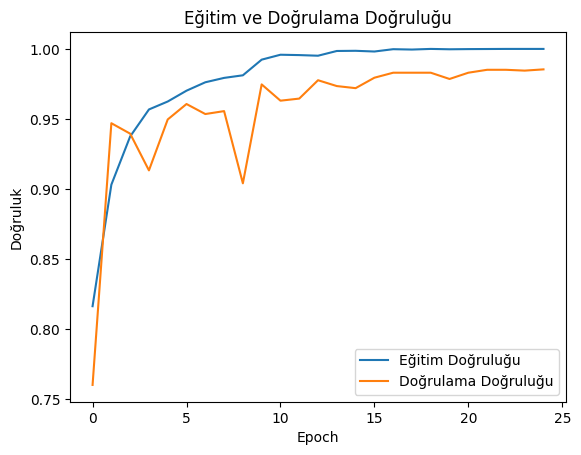

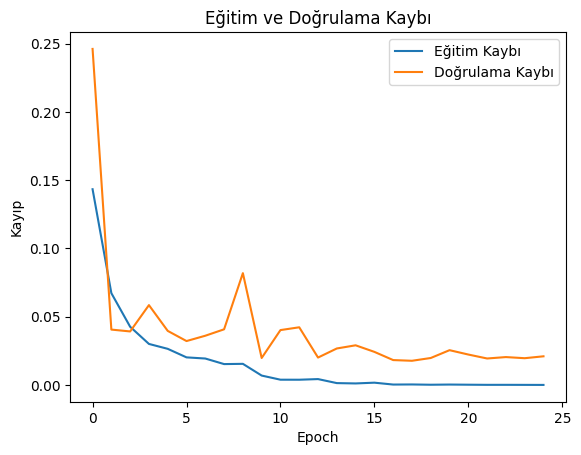

In [36]:
# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


In [39]:
# Tahmin Yapma
y_pred = model3.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 0.5 eşik değeri ile sınıflandırma

105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1363
           1       0.99      0.98      0.99      1996

    accuracy                           0.98      3359
   macro avg       0.98      0.98      0.98      3359
weighted avg       0.98      0.98      0.98      3359

Ortalama F1-score: 0.9830


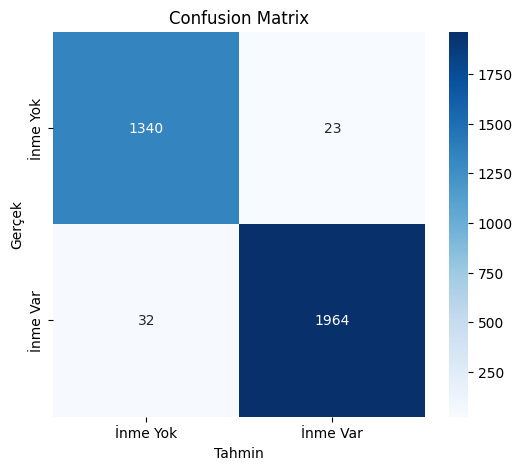

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Classification Report ve Confusion Matrix
report = classification_report(y_test, y_pred_class, output_dict=True)

# Ortalama F1-score hesapla (Makro Ortalama kullanarak)
average_f1_score = report['macro avg']['f1-score']

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print(f"Ortalama F1-score: {average_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['İnme Yok', 'İnme Var'], yticklabels=['İnme Yok', 'İnme Var'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()
